<a href="https://colab.research.google.com/github/aCStandke/GAN_Models/blob/main/CycleGanUnet_BinaryFocalEntropy_Gamma2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CycleGAN
> This is the CycleGAN implementation as detailed by tensorflow Core Tutorials [CycleGAN](https://www.tensorflow.org/tutorials/generative/cyclegan) to do image segemntation on the cityscape data as detailed by tensorflow datasets [datasets](https://www.tensorflow.org/datasets/catalog/cycle_gan). Additionally, the following sources were copy and pasted (I mean implemented 🤪): 
> 1.   [tf.data.Dataset](https://www.tensorflow.org/tutorials/load_data/images)
> 2.   [encode tensor into jpg image](https://stackoverflow.com/questions/40320271/how-do-we-use-tf-image-encode-jpeg-to-write-out-an-image-in-tensorflow)
> 3.   [downloading folders from Google Colab](https://stackoverflow.com/questions/50453428/how-do-i-download-multiple-files-or-an-entire-folder-from-google-colab)




In [1]:
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-tpoa1t2x
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-tpoa1t2x


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
# loading tensorflow's pix2pix model 
from tensorflow_examples.models.pix2pix import pix2pix
import pathlib
import os
import time
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output
from numpy import asarray
AUTOTUNE = tf.data.AUTOTUNE
import numpy as np
import copy


# Loading CityScape Dataset, Formatting into CycleGan Format, and Preprocesing 

In [3]:
# dataset_name = "cityscapes"
# _URL = f"http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz"
# path_to_zip = tf.keras.utils.get_file(fname=f"{dataset_name}.tar.gz", 
#                                       origin = _URL, 
#                                       extract = True)
# path_to_zip = pathlib.Path(path_to_zip)
# PATH = path_to_zip.parent/dataset_name

In [4]:
# list(PATH.parent.iterdir())

In [5]:
!tar -xf '/content/drive/MyDrive/Datasets/cityscapes.tar.gz'

In [6]:
x = sorted(os.listdir('/content/cityscapes/train/'))
y = sorted(os.listdir('/content/cityscapes/val/'))

In [7]:
def write_jpeg(data, filepath):
    g = tf.Graph()
    with g.as_default():
        data_t = tf.compat.v1.placeholder(dtype=tf.uint8)
        op = tf.image.encode_jpeg(data_t, format='rgb', quality=100)
        init = tf.compat.v1.initialize_all_variables()

    with tf.compat.v1.Session(graph=g) as sess:
        sess.run(init)
        data_np = sess.run(op, feed_dict={ data_t: data })

    with open(filepath, 'wb') as fd:
        fd.write(data_np)

def process_cityscapes(image_file, output_dir, phase, number):
  save_phase = 'test' if phase == 'val' else 'train'
  savedir = os.path.join(output_dir, save_phase)
    
  image = Image.open(image_file)
  image = asarray(image)
  width = image.shape[1] # get width of image
  width = width//2 # set width to 256
  
  # split the images to create X and Y
  semantic_seg_image = image[:, width:, :]
  driving_image = image[:, :width, :]
  
  savepath = os.path.join(savedir + 'A', f"{number}")
  write_jpeg(semantic_seg_image, savepath)
  savepath = os.path.join(savedir + 'B', f"{number}")
  write_jpeg(driving_image, savepath)

def make_directory(output_dir, phase):
  save_phase = 'test' if phase == 'val' else 'train'
  savedir = os.path.join(output_dir, save_phase)
  os.makedirs(savedir, exist_ok=True)
  os.makedirs(savedir + 'A', exist_ok=True)
  os.makedirs(savedir + 'B', exist_ok=True)
  print("Directory structure prepared at %s" % output_dir)

make_directory('/content/datasets/cityscapes', 'train')
for i in x:
  process_cityscapes(f"/content/cityscapes/train/{i}", '/content/datasets/cityscapes', 'train', i)
make_directory('/content/datasets/cityscapes', 'val')
for i in y:
  process_cityscapes(f"/content/cityscapes/val/{i}", '/content/datasets/cityscapes', 'val', i)

Directory structure prepared at /content/datasets/cityscapes
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Directory structure prepared at /content/datasets/cityscapes


In [8]:
TRAIN_BUFFER_SIZE = 3000
TEST_BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [9]:
def random_crop(image):
  cropped_image = image[:IMG_HEIGHT, :IMG_WIDTH, :3]
  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image


def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return img

def process_path(photos, segmentations):
  # Load the raw data from the file as a string
  img = tf.io.read_file(photos)
  img = decode_img(img)
  img = random_crop(img)
  img = normalize(img)
  seg = tf.io.read_file(segmentations)
  seg = decode_img(seg)
  seg = random_crop(seg)
  seg = normalize(seg)
  return img, seg

In [10]:
seg_list = []
photo_list = []
for i in sorted(os.listdir("/content/datasets/cityscapes/trainA/")):
  seg_list.append(os.path.join("/content/datasets/cityscapes/trainA/", i))
for i in sorted(os.listdir("/content/datasets/cityscapes/trainB/")):
  photo_list.append(os.path.join("/content/datasets/cityscapes/trainB/", i))

segmentations = tf.constant(seg_list)
photos =   tf.constant(photo_list)

train_ds = tf.data.Dataset.from_tensor_slices((photos, segmentations))
train_ds = train_ds.cache().map(process_path).shuffle(TRAIN_BUFFER_SIZE).batch(BATCH_SIZE)

In [11]:
def process_path_one(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  mg = random_crop(img)
  img = normalize(img)
  return img 
test_photo = tf.data.Dataset.list_files("/content/datasets/cityscapes/testB/*.jpg")
test_photo = test_photo.map(process_path_one, num_parallel_calls=AUTOTUNE).shuffle(TEST_BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
sample_photo, sample_seg = next(iter(train_ds))

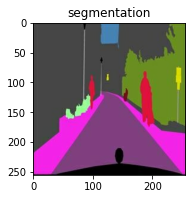

In [13]:
plt.subplot(121)
plt.title('segmentation')
plt.imshow(sample_seg[0] * 0.5 + 0.5)

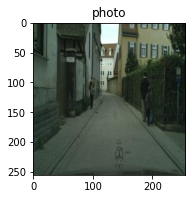

In [14]:
plt.subplot(121)
plt.title('photo')
plt.imshow(sample_photo[0] * 0.5 + 0.5)

# Importing and reusing the Pix2Pix model

Differences amoung Pix2Pix and CycleGAN and the tutorial:
1.   Cyclegan uses instance normalization instead of batch normalization.
2.   The CycleGAN paper uses a modified resnet based generator. This tutorial is using a modified form of the pix2pix unet generator for simplicity.










In [15]:
OUTPUT_CHANNELS = 3
# generator G: X -> Y
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
# generator F: Y -> X
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
# discriminator X: differentiates between image X and F(Y)
discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
# discriminator Y: differnentiates between image Y and G(X)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [16]:
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, None, None, 3)]   0         
                                                                 
 sequential_30 (Sequential)  (None, None, None, 64)    3072      
                                                                 
 sequential_31 (Sequential)  (None, None, None, 128)   131328    
                                                                 
 sequential_32 (Sequential)  (None, None, None, 256)   524800    
                                                                 
 zero_padding2d (ZeroPadding  (None, None, None, 256)  0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, None, None, 512)   2097152   
                                                           

In [17]:
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 sequential (Sequential)        (None, None, None,   3072        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 sequential_1 (Sequential)      (None, None, None,   131328      ['sequential[0][0]']             
                                128)                                                          

Testing out the genrators on the sample data

In [18]:
contrast = 20

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


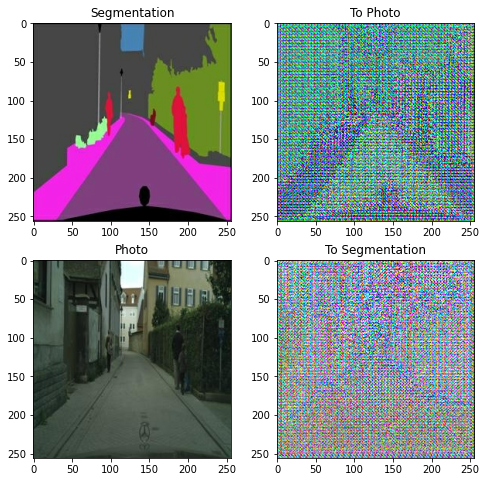

In [19]:
to_seg = generator_g(sample_photo)
to_photo = generator_f(sample_seg)
plt.figure(figsize=(8, 8))
contrast = 8 

imgs = [sample_seg, to_photo, sample_photo, to_seg]
title = ["Segmentation", "To Photo", "Photo", "To Segmentation"]

for i in range(len(imgs)):
  plt.subplot(2,2, i+1)
  plt.title(title[i])
  if i % 2 ==0:
    plt.imshow(imgs[i][0]*0.5+0.5)
  else:
    plt.imshow(imgs[i][0]*0.5*contrast+0.5)
plt.show()

Testing out the discriminator on the sample data

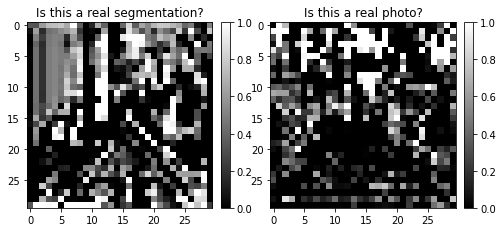

In [20]:
plt.figure(figsize=(8, 8))
img = discriminator_y(sample_seg)[0,..., -1]
plt.subplot(121)
plt.title('Is this a real segmentation?')
plt.imshow(img, cmap='gray')
plt.colorbar(fraction=0.046, pad=0.04)
plt.clim(0, 1)

img = discriminator_x(sample_photo)[0,..., -1]
plt.subplot(122)
plt.title('Is this a real photo?')
plt.imshow(img, cmap='gray')
plt.colorbar(fraction=0.046, pad=0.04)
plt.clim(0, 1)



# Loss Functions
*  Basically the same loss functions as Pix2Pix expect for Cycle consistency Loss and Identity Loss
  *  **Cycle consistency Loss**: means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the original sentence  
  *   **Identitly Loss**: As explained by the authors of [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/pdf/1703.10593.pdf)
    > For painting to photo (and thus also, photo to painting), we find that it is helpful to introduce an additional loss to encourage the mapping to preserve color composition between the input and output. In particular, we adopt the technique of Taigman et al. and regularize the generator to be near an identity mapping when real samples of the target domain are provided as the input to the generator: i.e., L<sub>identity</sub>(G, F) = E<sub>y∼pdata</sub>(y)
||G(y) − y||<sub>1</sub> + E<sub>x∼pdata</sub>(x)||F(x) − x||<sub>1</sub>.Without L<sub>identity</sub>, the generator G and F are free to
change the tint of input images when there is no need to.
For example, when learning the mapping between Monet’s
paintings and Flickr photographs, the generator often maps
paintings of daytime to photographs taken during sunset,
because such a mapping may be equally valid under the adversarial loss and cycle consistency loss.

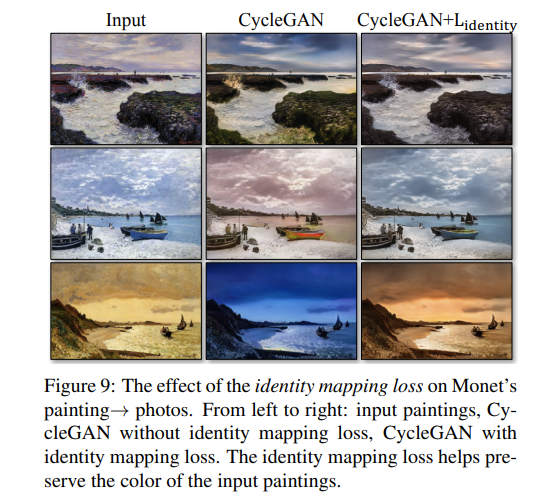









In [21]:
# parameter used to weight cycle consistency loss
LAMBDA = 10

In [22]:
# binary cross entrophy loss
# loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True) 

# binary Focal cross entorpy with gamma 2
loss_obj= tf.keras.losses.BinaryFocalCrossentropy(from_logits=True)

In [23]:
# discriminator loss
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss =  loss_obj(tf.zeros_like(generated), generated)
  # total disc loss
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5

In [24]:
# generator loss
def generator_loss(generated):
  # return  tf.keras.losses.mean_squared_error(tf.ones_like(generated), generated)
  return loss_obj(tf.ones_like(generated), generated)

In [25]:
# cycle consistency loss
def calc_cycle_loss(real_image, cycled_image):
  cycle_loss = tf.reduce_mean(tf.abs(real_image-cycled_image))
  return cycle_loss

In [26]:
# identity loss
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [27]:
# initializing the optimizers for the Generators and discriminators
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Training

In [28]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [29]:
# image pool class that stores 3 previously generated images 
class ImagePool(object):
  def __init__(self, maxsize=3):
    self.maxsize = maxsize
    self.num_img = 0
    self.images = []

  def __call__(self, image):
    if self.maxsize <= 0:
      return image
    if self.num_img < self.maxsize:
       self.images.append(image)
       self.num_img += 1
       return image
    if np.random.rand() > 0.5:
       idx = int(np.random.rand()*self.maxsize)
       tmp1 = copy.copy(self.images[idx])[0]
       self.images[idx][0] = image[0]
       idx = int(np.random.rand()*self.maxsize)
       tmp2 = copy.copy(self.images[idx])[1]
       self.images[idx][1] = image[1]
       return [tmp1, tmp2]
    else:
      return image

# class that implements the CycleGAN Algorithm 
class CycleGan():
  def __init__(self, train_ds, steps, lam, generator_g, generator_f, discriminator_x, discriminator_y, sample_photo):
    self.generator_g = generator_g
    self.generator_f = generator_f
    self.discriminator_x = discriminator_x
    self.discriminator_y = discriminator_y
    self.sample_photo = sample_photo
    self.train_ds = train_ds
    self.LAMBDA = lam
    self.steps = steps
    self.pool = ImagePool()
      
  # plotting method for the images
  def generate_images(self):
    prediction = self.generator_g(self.sample_photo)
    plt.figure(figsize=(12, 12))
    display_list = [self.sample_photo[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
    for i in range(2):
      plt.subplot(1, 2, i+1)
      if i % 2 ==0:
        plt.title(title[i])
        plt.imshow(display_list[i]*0.5+0.5)
        plt.axis('off')
      else:
        plt.title(title[i])
        plt.imshow(display_list[i]*0.5+0.5)
        plt.axis('off')
    plt.show()

  # method that fits the model by calling the train step and saves the segmentation generator
  def fit(self):
    start = time.time()
    for step, (image_photo, image_seg) in self.train_ds.repeat().take(steps).enumerate():
      n = 0
      self.train_step(image_photo, image_seg)
      if n % 10 == 0:
        clear_output(wait=True)
        self.generate_images()
        print ('Time taken for step {} is {} sec\n'.format(step + 1, time.time()-start))
      n += 1
    self.generator_g.save('/content/model/segmentation/')


  # method that trains the generators and discriminators 
  def train_step(self, real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
      # Generators
      fake_y = self.generator_g(real_x, training=True)
      cycled_x = self.generator_f(fake_y, training=True)
      fake_x = self.generator_f(real_y, training=True)
      cycled_y = self.generator_g(fake_x, training=True)
      # Image Buffer 
      # [fake_y, fake_x] = self.pool([fake_y, fake_x])
      # Identity 
      same_x = self.generator_f(real_x, training=True)
      same_y = self.generator_g(real_y, training=True)
      # Discriminator 
      disc_real_x = self.discriminator_x(real_x, training=True)
      disc_real_y = self.discriminator_y(real_y, training=True)
      disc_fake_x = self.discriminator_x(fake_x, training=True)
      disc_fake_y = self.discriminator_y(fake_y, training=True)
      # Adversarial loss
      gen_g_loss = generator_loss(disc_fake_y)
      gen_f_loss = generator_loss(disc_fake_x)
      # Calculate total cycle loss
      total_cycle_loss = self.LAMBDA*calc_cycle_loss(real_x, cycled_x) + self.LAMBDA*calc_cycle_loss(real_y, cycled_y)
      # Total generator loss = adversarial loss + cycle loss + identity loss
      total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
      total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
      # Discriminator loss
      disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
      disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    # Calculate the gradients 
    generator_g_gradients = tape.gradient(total_gen_g_loss,self.generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss,self.generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss,self.discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss,self.discriminator_y.trainable_variables)
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients,self.generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients,self.generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,self.discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,self.discriminator_y.trainable_variables))

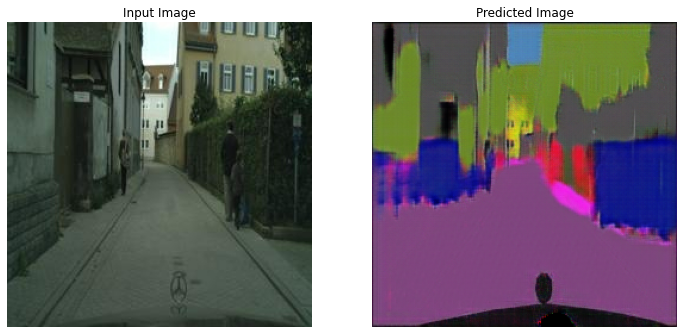

Time taken for step 29750 is 39127.40819168091 sec

INFO:tensorflow:Assets written to: /content/model/segmentation/assets


In [30]:
# define properties of the training run
n_epochs, n_batch = 10, 1
# calculate the number of batches per training epoch
bat_per_epo = int(2975/n_batch)
# calculate the number of training iterations
steps = bat_per_epo * n_epochs
# creating the CycleGAN object and fitting the model
x=CycleGan(train_ds=train_ds, steps=steps, lam=LAMBDA, generator_g=generator_g, generator_f=generator_f, discriminator_x=discriminator_x, discriminator_y=discriminator_y, sample_photo=sample_photo)
x.fit()

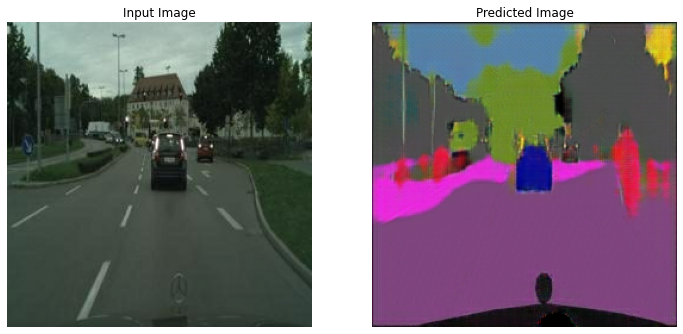

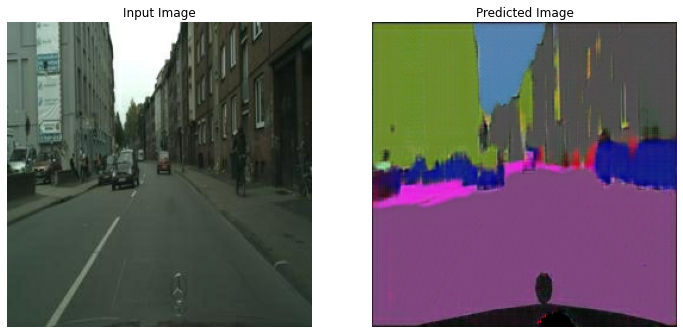

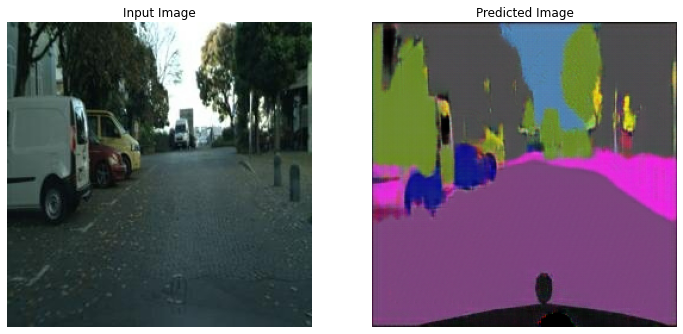

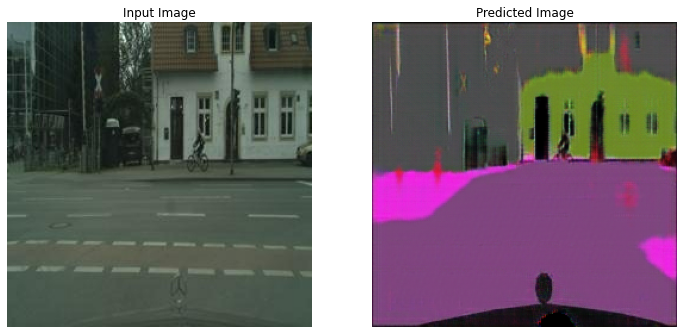

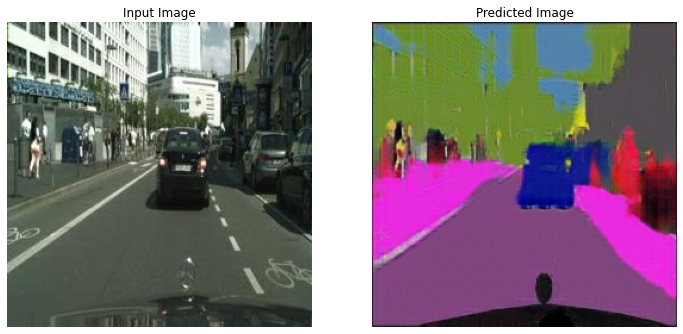

In [31]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

  
for inp in test_photo.take(5):
  generate_images(generator_g, inp)

In [32]:
# # plotting function for the images
# def generate_images(model, test_input):
#   prediction = model(test_input)

#   plt.figure(figsize=(12, 12))

#   display_list = [test_input[0], prediction[0]]
#   title = ['Input Image', 'Predicted Image']

#   for i in range(2):
#     plt.subplot(1, 2, i+1)
#     plt.title(title[i])
#     # getting the pixel values between [0, 1] to plot it.
#     plt.imshow(display_list[i] * 0.5 + 0.5)
#     plt.axis('off')
#   plt.show()

# @tf.function
# def train_step(real_x, real_y):
#   # persistent is set to True because the tape is used more than
#   # once to calculate the gradients.
#   with tf.GradientTape(persistent=True) as tape:
#     # Generator G translates X -> Y
#     # Generator F translates Y -> X.

#     fake_y = generator_g(real_x, training=True)
#     cycled_x = generator_f(fake_y, training=True)

#     fake_x = generator_f(real_y, training=True)
#     cycled_y = generator_g(fake_x, training=True)

#     # same_x and same_y are used for identity loss.
#     same_x = generator_f(real_x, training=True)
#     same_y = generator_g(real_y, training=True)

#     disc_real_x = discriminator_x(real_x, training=True)
#     disc_real_y = discriminator_y(real_y, training=True)

#     disc_fake_x = discriminator_x(fake_x, training=True)
#     disc_fake_y = discriminator_y(fake_y, training=True)

#     # calculate the loss
#     gen_g_loss = generator_loss(disc_fake_y)
#     gen_f_loss = generator_loss(disc_fake_x)

#     total_cycle_loss = calc_cycle_loss_x(real_x, cycled_x) + calc_cycle_loss_y(real_y, cycled_y)

#     # Total generator loss = adversarial loss + cycle loss
#     total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
#     total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

#     disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
#     disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

#   # Calculate the gradients for generator and discriminator
#   generator_g_gradients = tape.gradient(total_gen_g_loss, 
#                                         generator_g.trainable_variables)
#   generator_f_gradients = tape.gradient(total_gen_f_loss, 
#                                         generator_f.trainable_variables)

#   discriminator_x_gradients = tape.gradient(disc_x_loss, 
#                                             discriminator_x.trainable_variables)
#   discriminator_y_gradients = tape.gradient(disc_y_loss, 
#                                             discriminator_y.trainable_variables)

#   # Apply the gradients to the optimizer
#   generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
#                                             generator_g.trainable_variables))

#   generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
#                                             generator_f.trainable_variables))

#   discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
#                                                 discriminator_x.trainable_variables))

#   discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
#                                                 discriminator_y.trainable_variables))

In [33]:
# for epoch in range(EPOCHS):
#   start = time.time()
#   n = 0
#   for image_x, image_y in tf.data.Dataset.zip((train_photo, train_seg)):
#     train_step(image_x, image_y)
#     if n % 10 == 0:
#       print ('.', end='')
#     n += 1
#   clear_output(wait=True)
#   # Using a consistent image  so that the progress of the model
#   # is clearly visible.
#   generate_images(generator_g, sample_photo)
#   print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
# generator_g.save('/content/model/segmentation/')